In [1]:
import json

# set the data subset to use
subset = 1
# load data
data = json.load(open('../github/visdial/datasets/annotations/visdial_1.0_val.json'))['data']
# load questions
questions = data['questions']
# load answers
answers = data['answers']
# load history: captions of images and the dialog rounds
dialogs = data['dialogs']

In [2]:
'''Note: While doing the History Graph modeling,
Node 0 -> Caption
Node 1:11 -> Question-Answer rounds with Question-and-<Answered Answer> Pairs'''

# storing the history
history = []

for index in range(len(dialogs)):
    # storing the image caption
    caption = dialogs[index]['caption']
    # storing each of the dialog rounds
    q_and_a = []
    # for the dialog rounds
    for rounds in range(10):
        # question key and the question
        question_key = dialogs[index]['dialog'][rounds]['question']
        question = questions[question_key]
        # answer key and the selected answer
        answer_key = dialogs[index]['dialog'][rounds]['answer']
        answer = answers[answer_key]
        # append to q_and_a: note that the questions and answers have been separated by a "? " to mimic the GOG history features structure
        q_and_a.append("? ".join([question, answer]))
    # add the caption to the zero'th position for continuity (doesn't really matter since Graphs preserve the relational structure between the nodes)
    q_and_a.insert(0, caption)
    # append to history
    history.append(q_and_a)


In [3]:
# save the history structure for coreference resolution
with open('../embeddings/history/'+ str(subset) +'/history_val.json', 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    # if the data is nested
    json.dump(history, f, indent=2)

In [4]:
import json

'''Create a list of history batches for each dialog round where:
    - each history batch contains a fractal sequence of history entries, i.e. the [caption], [caption, round1], [caption, round1, round2], etc.'''
history_batch = []
for history_entry in history:
    batches = []
    # ingore the last history entry as it is the current question for round 10
    for i in range(1, len(history_entry)):
        batches.append(history_entry[:i])
    history_batch.append(batches)

'''Save the history batches to a json file'''
with open('../embeddings/history/' + str(subset) + '/history_batch_val.json', 'w') as f:
    json.dump(history_batch, f)

In [5]:
import json
'''Load the saved history batches'''

with open('../embeddings/history/' + str(subset) + '/history_batch_val.json', 'r') as f:
    history_batch = json.load(f)

# example of a history batch showing the number of nodes in each batch
[len([h for h in batch]) for batch in history_batch[0]] 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [6]:
import neuralcoref
import spacy

# Load the Spacy model and add neural coref to SpaCy's pipe
nlp = spacy.load('en')
neuralcoref.add_to_pipe(nlp)

'''Takes two strings and returns a boolean value indicating whether they are coreferent or not
    Method: Uses the neuralcoref library to compute the coref_scores for the document containing the two strings
            doc._.coref_scores is a dictionary with keys as the coreferent entities and a dict of all the coreferent entities and their scores as the values
            Get a list of all values in this dict_list that are positive:
                Return true if among these, doc._.coref_scores.keys() and doc._.coref_score entities are not in the same strings''' 

def is_coreferent(string1, string2):
    # get the document
    doc = nlp(string1 + " " + string2)
    # get the coref_scores
    coref_scores = doc._.coref_scores
    # get the list of all values in this dict_list that are positive
    for keys, values in coref_scores.items():
        for key, value in values.items():
            if value > 0:
                # check if the first element is from set 1 and third is from set 2 or vice versa
                if (keys.text in string1 and key.text in string2) or (keys.text in string2 and key.text in string1):
                    return True

is_coreferent("My mother's name is Sanchita.", "She likes my home-cooked food.")

/bigpool/homes/chatterjee/anaconda3/envs/coreference/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [7]:
'''Loop through all history batches and compute the edge list and the adj list for each history entry'''
from tqdm import tqdm

edge_list_batch = []
for batch in tqdm(history_batch):
    edge_list = [] # initialize the edge list for all history entries
    for entry in batch:
        edge_list_entry = [] # initialize the edge list for each history entry
        compare_list = [entry[0]] # initialize the compare list for each history entry initialized with the caption
        for index in entry[1:]:
            for compare in compare_list:
                if is_coreferent(index, compare):
                    # an edge between two nodes is indicated by both (0, 1) and (1, 0) since the graph is undirected
                    edge_list_entry.append((entry.index(index), entry.index(compare))) 
                    edge_list_entry.append((entry.index(compare), entry.index(index))) 
            compare_list.append(index)
        edge_list.append(edge_list_entry)
    edge_list_batch.append(edge_list)

with open('../embeddings/history/'+ str(subset) +'/edge_list_batch_val.json', 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    # if the data is nested
    json.dump(edge_list_batch, f)

100%|██████████| 2064/2064 [1:05:11<00:00,  1.90s/it]


In [8]:
'''Convert the edge lists to an Adjacency list for each history entry in each history batch'''

adj_list_batch = []
for batch, h_batch in zip(tqdm(edge_list_batch), history_batch):
    adj_list = []
    for element, h_element in zip(batch, h_batch):
        # size of the adjacency list is the number of nodes in the graph
        size = len(h_element)
        # initialize the adjacency list with empty lists
        adj_list_element = [[0 for i in range(size)] for j in range(size)]
        # add the edges to the adjacency list
        if len(element) != 0:
            for row, col in element:
                adj_list_element[row][col] = 1
        # add the adjacency list element to the adjacency list
        adj_list.append(adj_list_element)
    adj_list_batch.append(adj_list)

# save the adjacency list batch to a json file
with open('../embeddings/history/'+ str(subset) +'/adj_list_batch_val.json', 'w') as f:
    json.dump(adj_list_batch, f)

100%|██████████| 2064/2064 [00:00<00:00, 4353.56it/s]


In [9]:
import pandas as pd

def load_glove_model(glove_file):
    readable_name = "-".join(glove_file.rstrip('.txt').split('/')[-1].split(".")).capitalize()
    print(f"Loading {readable_name} Model:")
    df = pd.read_csv(glove_file, sep=" ", quoting=3, header=None, index_col=0)
    glove_model = {key: val.values for key, val in df.T.items()}
    print(f"Done. {readable_name} with a vocabulary of {len(glove_model)} words was loaded!")
    return glove_model

glove_6b_300 = load_glove_model('../embeddings/glove/glove.6B.300d.txt')

Loading Glove-6b-300d Model:
Done. Glove-6b-300d with a vocabulary of 399998 words was loaded!


In [10]:
'''Tokenize a sentence using a glove model, pass it through an LSTm and return the last LSTM hidden state'''
from nltk.tokenize import RegexpTokenizer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


def sentence_LSTM(glove_model, sentence):
    # tokenize the sentence
    tokenizer = RegexpTokenizer(r'\w+')  # to remove punctuations
    tokenized_sentence = tokenizer.tokenize(sentence.lower())

    # get the glove embedding for each word in the sentence
    glove_embeddings = []
    for word in tokenized_sentence:
        if word in glove_model.keys():
            glove_embeddings.append(glove_model[word])
        else:
            glove_embeddings.append(glove_model['unk'])

    # convert the glove embeddings to a numpy array
    glove_embeddings = np.array(glove_embeddings)
    # convert the glove embeddings to a tensor
    glove_embeddings = torch.tensor(glove_embeddings).float()

    # pass the glove embeddings through an LSTM
    # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    lstm = nn.LSTM(input_size=300, hidden_size=300,
                   num_layers=1, batch_first=True)
    lstm_out, (h_n, c_n) = lstm(
        glove_embeddings.view(1, len(tokenized_sentence), 300))

    # return the last hidden state
    return h_n.squeeze()

'''Testing LSTM hidden state output'''
sentence_LSTM(glove_6b_300, "What is the color of the shirt?").shape

torch.Size([300])

In [11]:
from tqdm import tqdm
import pickle

history_LSTM_batch = []
for batch in tqdm(history_batch):
    history_LSTM = []
    '''Each entry in the History LSTM contains a list of the LSTM hidden state for each history node entry of a round of dialog'''
    for entry in batch:
        history_LSTM.append(torch.tensor(np.array([sentence_LSTM(glove_6b_300, index).detach().numpy() for index in entry])))
    history_LSTM_batch.append(history_LSTM)

with open('../embeddings/history/'+ str(subset) +'/history_LSTM_batch_val.pkl', 'wb') as f:
    pickle.dump(history_LSTM_batch, f)

100%|██████████| 2064/2064 [09:46<00:00,  3.52it/s]


In [12]:
history_LSTM_batch[0][9].shape

torch.Size([10, 300])

In [1]:
import json
import pickle

# set the subset
subset = 1

'''Load the edge list batch'''
with open('../embeddings/history/'+ str(subset) +'/edge_list_batch_val.json', 'r') as f:
    edge_list_batch = json.load(f)

'''Load the history LSTM batch'''
with open('../embeddings/history/'+ str(subset) +'/history_LSTM_batch_val.pkl', 'rb') as f:
    history_LSTM_batch = pickle.load(f)

'''Load the adjacency list batch'''
with open('../embeddings/history/'+ str(subset) +'/adj_list_batch_val.json', 'r') as f:
    adj_list_batch = json.load(f)

In [2]:
'''Intialize the graph with pytorch geometric'''
import pickle
import torch
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm

'''Create a list of Data objects for each question where:
    - x is the history_LSTM
    Note: Each history_LSTM is a list of the LSTM hidden states for each history node entry of a round of dialog
    - edge_index is the edge list where they are contiguous'''

history_graphs_batch = []
for history_LSTM, edge_list in zip(tqdm(history_LSTM_batch), edge_list_batch):
    history_graphs = []
    for i in range(len(history_LSTM)):
        history_graphs.append(Data(x=torch.FloatTensor(np.array(history_LSTM[i])),
                                edge_index=torch.LongTensor(np.array(edge_list[i])).t().contiguous()))
    history_graphs_batch.append(history_graphs)

'''Save the Data objects to a file'''
with open('../embeddings/history/' + str(subset) + '/history_graphs_batch_val.pkl', 'wb') as f:
    pickle.dump(history_graphs_batch, f)

100%|██████████| 2064/2064 [00:01<00:00, 1454.71it/s]


In [3]:
import pickle

'''Load the Data objects'''
with open('../embeddings/history/' + str(subset) + '/history_graphs_batch_val.pkl', 'rb') as f:
    history_graphs_batch = pickle.load(f)

history_graphs_batch[0][0].view()

AttrView(store=Data(x=[1, 300], edge_index=[0]), attr=DataTensorAttr(group_name=None, attr_name=<FieldStatus.UNSET: 1>, index=<FieldStatus.UNSET: 1>))

In [4]:
# testing the number of nodes in each graph in the batch
[i.num_nodes for i in history_graphs_batch[1]]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

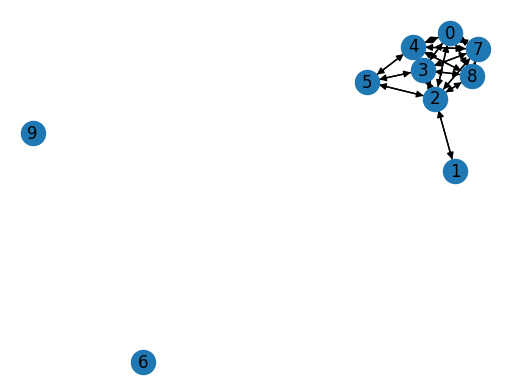

<Figure size 400x400 with 0 Axes>

In [5]:
'''Visualize the first fully connected history graph'''
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

# convert a pytorch geometric graph to a networkx graph
def visualize_graph(graph):
    G = to_networkx(graph)
    # initialize the figure and axes | Note: This somehow gets around the "TypeError: '_AxesStack' object is not callable"
    fig, ax = plt.subplots() 
    # draw the graph
    nx.draw(G, ax=ax, with_labels=True)
    # set the figure size 4x4
    plt.figure(figsize=(4, 4))

visualize_graph(history_graphs_batch[0][9])

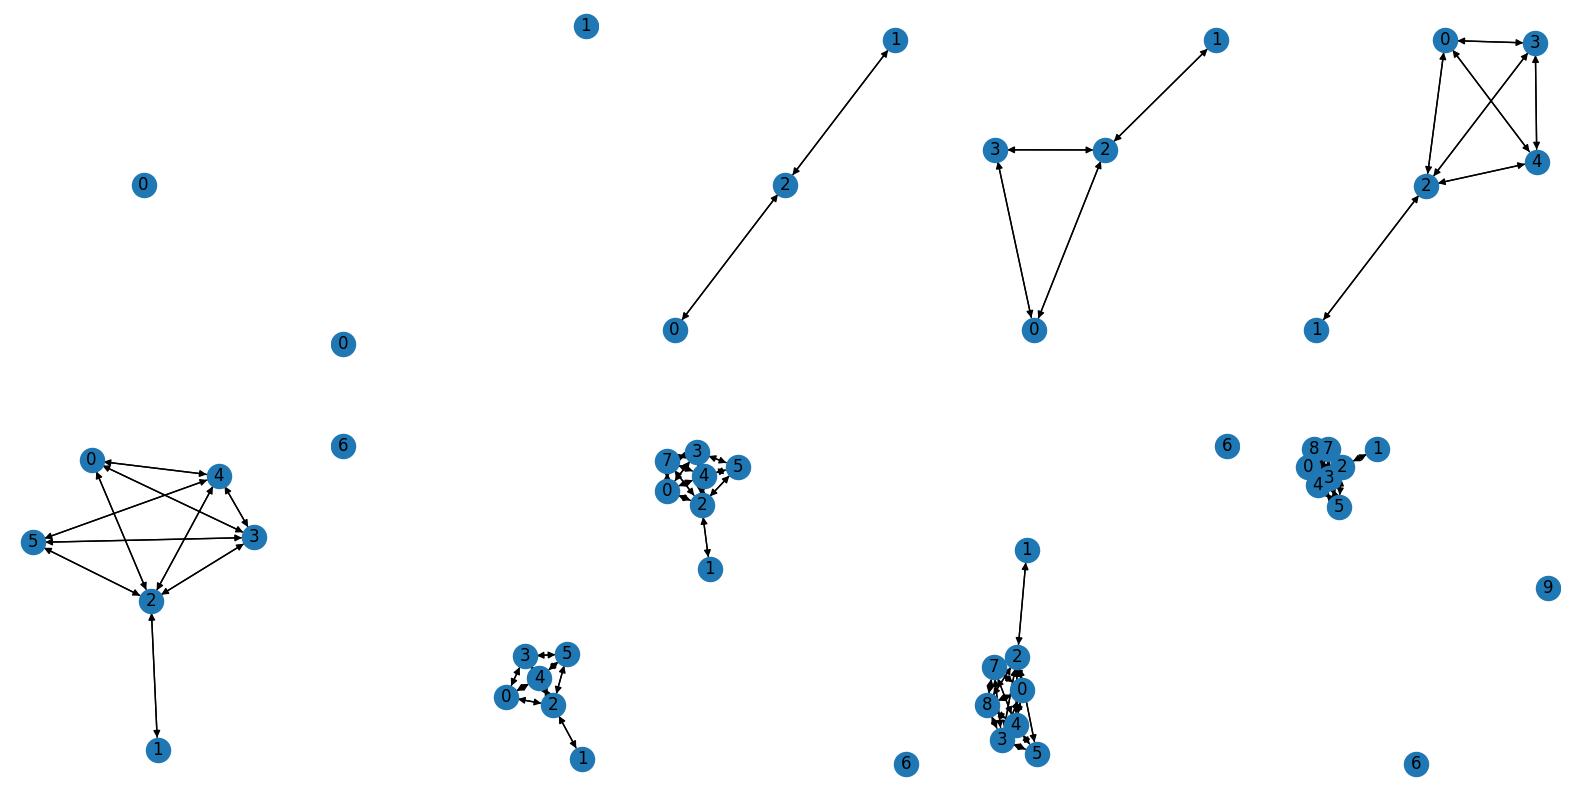

In [6]:
'''Visualize 10 fully connected history graphs for the history_graphs_batch[0] using seaborn'''
import seaborn as sns
import matplotlib.pyplot as plt

# initialize the figure and axes
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
# iterate through the first 10 graphs
for i in range(10):
    # convert a pytorch geometric graph to a networkx graph
    G = to_networkx(history_graphs_batch[0][i])
    # draw the axes
    sns.set_style("darkgrid")
    # draw the graph
    nx.draw(G, ax=ax[i//5, i%5], with_labels=True)


In [7]:

# Progress bar
from tqdm.notebook import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Torchvision
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl


class GATLayer(nn.Module):

    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads

        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(
            num_heads, 2 * c_out))  # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        # We need to calculate the attention logits for every edge in the adjacency matrix
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        # Returns indices where the adjacency matrix is not 0 => edges
        edges = adj_matrix.nonzero(as_tuple=False)
        node_feats_flat = node_feats.view(
            batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:, 0] * num_nodes + edges[:, 1]
        edge_indices_col = edges[:, 0] * num_nodes + edges[:, 2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat,
                               index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat,
                               index=edge_indices_col, dim=0)
        ], dim=-1)  # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0

        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(
            adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[..., None].repeat(
            1, 1, 1, self.num_heads) == 1] = attn_logits.reshape(-1)

        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats

In [8]:
'''Initialize the GAT layer with:
- input dimension of 300 (the dimensionality of the node features)
- output dimension of 512 (the dimensionality of the output features)
- 4 attention heads
- attention heads are not concatenated
- alpha is set to 0.2
Note: The features here are set from the GoG Paper'''

gat_layer = GATLayer(c_in=300, c_out=512, num_heads=4, concat_heads=False, alpha=0.2)

# testing the GAT layer with the first history graph
with torch.no_grad():    
    # note that we have to unsqueeze the node features to fit the GAT input shape
    out_feats = gat_layer(history_graphs_batch[0][9].x.unsqueeze(0), torch.tensor([adj_list_batch[0][9]]), print_attn_probs=False)
    
print(history_graphs_batch[0][9].x.shape)
print(out_feats.squeeze(0).shape)


torch.Size([10, 300])
torch.Size([10, 512])


In [9]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm

'''Copy the history_graphs_batch'''
history_batch_gat = history_graphs_batch.copy()

'''Doing the same for the entire batch'''
for i in tqdm(range(len(history_batch_gat))):
    for j in range(len(history_batch_gat[i])):
        history_batch_gat[i][j].x = gat_layer(history_batch_gat[i][j].x.unsqueeze(0), torch.tensor([adj_list_batch[i][j]]), print_attn_probs=False).squeeze(0)

'''Save the History Graphs Batch with GAT features'''
with open('../embeddings/history/' + str(subset) + '/history_batch_gat_val.pkl', 'wb') as f:
    pickle.dump(history_batch_gat, f)

'''Checking the output shape'''
print(history_batch_gat[0][9].x.shape)

100%|██████████| 2064/2064 [00:14<00:00, 137.72it/s]


torch.Size([10, 512])


In [10]:
import dgl
from dgl.nn import GlobalAttentionPooling

# initialize the gate layer
gate_nn = torch.nn.Linear(512, 1)
# initialize the GlobalAttentionPooling layer
gap = GlobalAttentionPooling(gate_nn)

history_batch_GAP = []
'''For each history batch'''
for i in tqdm(range(len(history_batch_gat))):
    '''For each history graph, we need to convert it to a DGL graph and then apply the GlobalAttentionPooling layer'''
    history_GAP = []
    for j in range(len(history_batch_gat[i])):
        # initialize an empty DGL graph with the number of nodes equal to the number of nodes in the history graph
        g = dgl.graph(([], []), num_nodes=history_batch_gat[i][j].num_nodes)
        # initialize the node features for the DGL graph where each node has 512 features
        g_node_feats = history_batch_gat[i][j].x
        # add the edges to the dgl graph where edges are the edges from the pytorch geometric graph
        if history_batch_gat[i][j].edge_index.shape[0] == 0:
            pass
        else:
            g.add_edges(history_batch_gat[i][j].edge_index[0], history_batch_gat[i][j].edge_index[1])
        # apply the GlobalAttentionPooling layer to the DGL graph
        out = gap(g, g_node_feats).squeeze(0)
        # append the output to the history_GAP list
        history_GAP.append(out)
    # append the history_GAP list to the history_batch_GAP list
    history_batch_GAP.append(history_GAP)

'''Save the History Graphs Batch with GAP features'''
with open('../embeddings/history/' + str(subset) + '/history_batch_GAP_val.pkl', 'wb') as f:
    pickle.dump(history_batch_GAP, f)

100%|██████████| 2064/2064 [00:22<00:00, 93.34it/s] 
